In [1]:
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.random_projection import (
    johnson_lindenstrauss_min_dim,
    GaussianRandomProjection,
    SparseRandomProjection,
)
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding


import numpy as np
import matplotlib.pyplot as plt

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)


# PCA


In [2]:
W2 = m = 60
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)


In [3]:
pca.components_


array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

In [4]:
pca.explained_variance_ratio_


array([0.7578477 , 0.15186921])

In [5]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1


In [6]:
pca = PCA(n_components=d)
x_reduced = pca.fit_transform(X_train)


[]

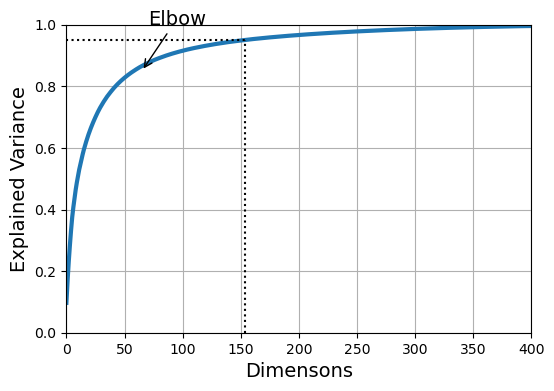

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.xlabel("Dimensons")
plt.ylabel("Explained Variance")
plt.axis([0, 400, 0, 1])
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 1), arrowprops=dict(arrowstyle="->"))
plt.grid(True)
plt.plot()


## Incremental PCA


In [8]:
# n_batches = 100
# inc_pca = IncrementalPCA(n_components=d)
# for X_batch in np.array_split(X_train, n_batches):
#     inc_pca.partial_fit(X_batch)

# X_reduced = inc_pca.transform(X_train)


# Random Projection


In [9]:
m, e = 5000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=e)
d


7300

Now we can just generate a random matrix P of shape [d, n], where each item is sampled randomly from a Gaussian distribution with mean 0 and variance 1 / d, and use it to project a dataset from n dimensions down to d


In [10]:
n = 20000
np.random.seed(23)
P = np.random.randn(d, n) / np.sqrt(d)
X = np.random.randn(m, n)
X_reduced = X @ P.T


Scikit-Learn offers a GaussianRandomProjection class to do exactly what we just did: when you call its fit() method, it uses johnson_lindenstrauss_min_dim() to determine the output dimensionality


In [11]:
gaussian_rnd_proj = GaussianRandomProjection(eps=e, random_state=24)
X_reduced_gaussian = gaussian_rnd_proj.fit_transform(X)


Scikit-Learn also provides a second random projection transformer, known as SparseRandomProjection. It determines the target dimensionality in the same way, generates a random matrix of the same shape, and performs the projection identically. The main difference is that the random
matrix is sparse. This means it uses much less memory: about 25 MB instead of almost 1.2 GB in the preceding example


In [12]:
sparse_rnd_proj = SparseRandomProjection(random_state=45)
X_reduced_sparse = sparse_rnd_proj.fit_transform(X)


In [13]:
print("GaussianRandomProjection fit")
%timeit GaussianRandomProjection(random_state=42).fit(X)
print("SparseRandomProjection fit")
%timeit SparseRandomProjection(random_state=42).fit(X)

gaussian_rnd_proj = GaussianRandomProjection(random_state=42).fit(X)
sparse_rnd_proj = SparseRandomProjection(random_state=42).fit(X)
print("GaussianRandomProjection transform")
%timeit gaussian_rnd_proj.transform(X)
print("SparseRandomProjection transform")
%timeit sparse_rnd_proj.transform(X)

# LLE


In [16]:
X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=34)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=34)
X_unrolled = lle.fit_transform(X_swiss)


In [17]:
# extra code – this cell generates and saves Figure 8–10

from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))
plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1], c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

plt.title("Unrolled swiss roll using LLE")
plt.show()
